
# <font color="green">Комплекс из трёх лабораторных работ, по классификации изображений разными типами нейронных сетей с использованием Hugging Face</font>

---

# <font color="green">Лабораторная работа №3, [Vision Transformer (ViT)](https://huggingface.co/docs/transformers/en/model_doc/vit)</font>

---




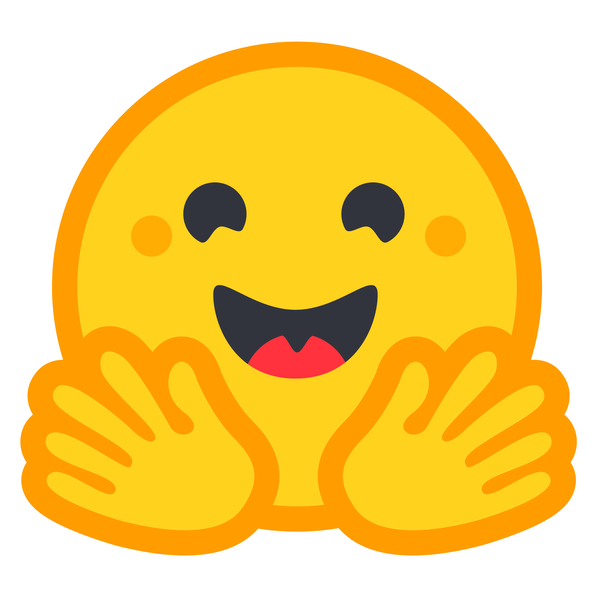

# <font color="green">Цель данной работы - научиться классифицировать изображения с использованием [Vision Transformer (ViT)](https://huggingface.co/docs/transformers/en/model_doc/vit), используя библиотеки Hugging Face. Также изучим все нюансы и подводные камни</font>

[Vision Transformer (ViT)](https://huggingface.co/docs/transformers/en/model_doc/vit) — это архитектура глубокого обучения для обработки изображений, основанная на механизме трансформеров, изначально разработанных для задач обработки естественного языка (NLP). В отличие от традиционных свёрточных нейронных сетей (CNN), ViT использует самовнимание (self-attention) для анализа глобальных зависимостей между различными частями изображения.

### Шаг 1. Установка и импорт зависимостей

Сформируем окружение для:

- Загрузки и предобработки изображений

- Обучения или использования ViT модели

- Оценки качества классификации


In [ ]:
# === Установка зависимостей ===
# Устанавливает необходимые библиотеки для работы с моделями Hugging Face
# - transformers: ядро для работы с нейросетевыми моделями
# - datasets: инструменты для загрузки и обработки данных
# - accelerate: оптимизация вычислений на GPU/TPU
# - huggingface_hub: доступ к репозиториям моделей и датасетов
!pip install transformers datasets accelerate huggingface_hub -q

# === Импорт основных библиотек ===
import torch  # Фреймворк для тензорных операций и нейросетей
import numpy as np  # Математические операции и работа с массивами
import matplotlib.pyplot as plt  # Визуализация данных и графиков
import random  # Генерация случайных значений (для воспроизводимости)
from PIL import Image  # Обработка изображений (загрузка, преобразования)

# === Импорт компонентов Hugging Face ===
from datasets import load_dataset  # Для загрузки стандартных датасетов
from huggingface_hub import hf_hub_download  # Для скачивания моделей/данных

# === Импорт компонентов ViT ===
from transformers import (
    ViTFeatureExtractor,  # Подготовка изображений к подаче в модель
    ViTForImageClassification,  # Готовая модель ViT для классификации
    Trainer,  # Автоматизация процесса обучения
    TrainingArguments  # Конфигурация параметров обучения
)

# === Импорт вспомогательных инструментов ===
from sklearn.metrics import accuracy_score  # Расчет метрики точности
from torch.utils.data import DataLoader  # Итеративная загрузка данных батчами

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Шаг 2. Загрузка датасета CIFAR-100 (Hugging Face)

Хоть модель Vision Transformer (ViT) уже обучена, в рамках данной работы будет рассмотрено дообучение модели, для наглядного примера и сравнения показателей. Дообучать модель будем на наборе данных из Hugging Face

CIFAR-100 — классический датасет для обучения моделей компьютерного зрения, содержащий 60 тысяч маленьких изображений (32x32 пикселя), разбитых на 100 категорий. Используется как эталон для проверки эффективности алгоритмов распознавания образов. В коде берётся сокращённая версия для ускорения тестирования модели.

In [ ]:
# Загрузка датасета CIFAR-100 из репозитория Hugging Face
# Дает 60k изображений 32x32 (50k train / 10k test) с 100 классами
dataset = load_dataset("cifar100")

# Создаем уменьшенные подмножества для демонстрации:
# - 1000 случайных тренировочных примеров (вместо 50k)
# - 200 тестовых примеров (вместо 10k)
# Это ускорит обучение в демо-режиме
train_subset = dataset["train"].select(range(2000))
test_subset = dataset["test"].select(range(400))

# Получаем список названий 100 классов датасета
# Например: ['apple', 'aquarium_fish', 'baby', ...]
label_names = dataset["train"].features["fine_label"].names


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.98k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/119M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/23.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

## <font color="red">Задание 1.

<font color="red">Использовать другое подмножество данных, и сравнить результаты работы, написать вывод в поле в конце ноутбука

Подсказка: например увеличить диапазон train до 2000, а test до 400, и сравнить до и после</font>

### Шаг 3. Подготовка FeatureExtractor

Загрузим стандартный обработчик изображений FeatureExtractor для ViT. Он автоматически преобразует картинки в размер 224x224 и подготавливает их для модели, как того требует архитектура Vision Transformer. Обработчик скачивается с серверов Hugging Face и включает все необходимые преобразования: изменение размера, нормализацию и разбиение на патчи.

In [ ]:

# ViT обычно работает с входными изображениями 224x224 (для ViT-base).
# Используем ViTFeatureExtractor из библиотеки transformers, скачивается с Hugging Face https://huggingface.co/google/vit-base-patch16-224-in21k

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


### Шаг 4. Предобработка (resize, normalize) и подготовка датасета

Ключевые моменты:

- Каждое изображение преобразуется в формат, понятный ViT

- Исходные данные (32x32) автоматически приводятся к 224x224

- На выходе получаем датасет, готовый для обучения модели

In [ ]:
# Функция для предобработки каждого изображения в датасете
def transform_examples(example):
    # Применяем feature_extractor для преобразования изображения:
    # - изменяет размер до 224x224
    # - нормализует пиксели
    # - разбивает на патчи 16x16
    # return_tensors="pt" - возвращает тензоры PyTorch
    inputs = feature_extractor(example['img'], return_tensors="pt")

    # Сохраняем преобразованные пиксели и метку класса
    example['pixel_values'] = inputs["pixel_values"][0]  # Тензор с пикселями
    example['labels'] = example['fine_label']  # Используем детальную метку класса

    return example

# Применяем функцию преобразования ко всему тренировочному и тестовому датасетам
train_dataset = train_subset.map(transform_examples)
test_dataset = test_subset.map(transform_examples)

# Удаляем исходные колонки, которые больше не нужны:
# - img (исходное изображение уже обработано)
# - fine_label (перенесено в labels)
# - coarse_label (не используется)
train_dataset = train_dataset.remove_columns(['img', 'fine_label', 'coarse_label'])
test_dataset = test_dataset.remove_columns(['img', 'fine_label', 'coarse_label'])


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

### Шаг 5. Загрузка модели ViT

Ключевые особенности:

- Модель уже обучена распознавать общие признаки изображений

- Мы адаптируем её для конкретной задачи (100 классов CIFAR-100)

- Сохраняются все предобученные веса, кроме последнего классификационного слоя

In [ ]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=100
)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Шаг 6. Настройка аргументов обучения (TrainingArguments)

In [ ]:
# Настройка параметров обучения модели
training_args = TrainingArguments(
    output_dir="./results_vit_cifar100",  # Папка для сохранения результатов и чекпоинтов
    per_device_train_batch_size=16,      # Размер батча для обучения (на каждом устройстве)
    per_device_eval_batch_size=16,       # Размер батча для валидации
    num_train_epochs=2,                  # Количество эпох обучения
    eval_strategy="epoch",               # Оценка модели после каждой эпохи
    save_strategy="epoch",               # Сохранение модели после каждой эпохи
    logging_steps=10,                    # Частота логирования (каждые 10 шагов)
    report_to="none",                    # Отключение отправки отчетов (например, в TensorBoard)
    remove_unused_columns=False          # Сохранение всех колонок в датасете
)

# Что это дает:
# - Контролируемый процесс обучения с сохранением промежуточных результатов
# - Баланс между скоростью (размер батча) и качеством (количество эпох)
# - Возможность анализа обучения через логи


### Шаг 7. Функция подсчёта метрик (accuracy)

 Назначение compute_metrics:
- Оценивает качество модели по метрике accuracy
- Используется Trainer'ом при валидации после каждой эпохи
- Позволяет отслеживать прогресс обучения

In [ ]:

# Функция для вычисления метрик качества модели
def compute_metrics(eval_pred):
    # Распаковываем входные данные:
    logits, labels = eval_pred  # logits - выход модели, labels - истинные метки

    # Преобразуем logits в предсказанные классы:
    # argmax выбирает класс с максимальной вероятностью для каждого примера
    preds = np.argmax(logits, axis=-1)

    # Вычисляем точность (доля правильных предсказаний)
    acc = accuracy_score(labels, preds)

    # Возвращаем метрику в виде словаря
    return {"accuracy": acc}



### Шаг 8. Создаём Trainer

Проверим предобученную ViT-модель перед дообучением. Сначала оценим общую точность на тестовых данных, затем наглядно продемонстрируем работу модели на случайном изображении - выводим саму картинку с подписью, где сравниваем реальный класс с предсказанным. Всё это происходит в режиме без обучения, чтобы проверить исходные возможности модели.




=== Тест модели ДО дообучения ===


Accuracy (до обучения): 0.0150


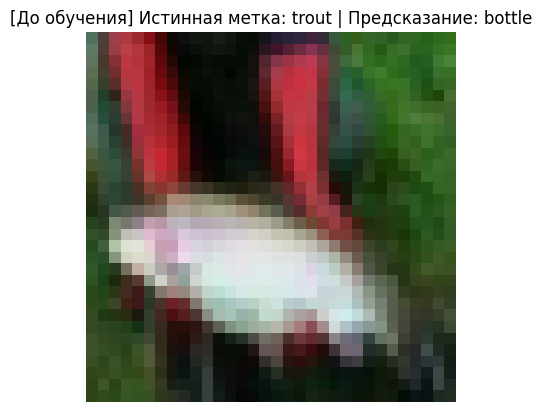

In [ ]:
# Инициализация объекта Trainer для управления процессом обучения
trainer = Trainer(
    model=model,  # Модель ViT для классификации изображений
    args=training_args,  # Параметры обучения (размер батча, количество эпох и т.д.)
    train_dataset=train_dataset,  # Обработанный тренировочный датасет
    eval_dataset=test_dataset,  # Тестовый датасет для валидации
    compute_metrics=compute_metrics  # Функция для расчета метрик точности
)

# Проверка начальной точности предобученной модели
print("\n=== Тест модели ДО дообучения ===")
results_before = trainer.evaluate()  # Оценка на тестовом наборе
print(f"Accuracy (до обучения): {results_before['eval_accuracy']:.4f}")  # Вывод точности

# Визуальная проверка на случайном изображении
random_idx = random.randint(0, len(test_subset) - 1)  # Случайный индекс
original_img = test_subset[random_idx]["img"]  # Берем оригинальное изображение
true_label_idx = test_subset[random_idx]["fine_label"]  # Истинная метка класса
true_label_name = label_names[true_label_idx]  # Название класса

# Подготовка изображения для модели
inputs = feature_extractor(original_img, return_tensors="pt")  # Преобразование в тензор
device = model.device  # Определяем устройство (GPU/CPU)
inputs = {k: v.to(device) for k, v in inputs.items()}  # Перенос данных на нужное устройство

# Предсказание без изменения весов модели
with torch.no_grad():  # Отключаем расчет градиентов
    outputs = model(**inputs)  # Прямой проход через модель
    logits = outputs.logits  # Получаем выходные логиты

# Обработка и визуализация результатов
probs = torch.nn.functional.softmax(logits, dim=1)[0].cpu().numpy()  # Вероятности классов
top_pred_idx = np.argmax(probs)  # Индекс предсказанного класса

plt.imshow(original_img)  # Показываем изображение
plt.title(f"[До обучения] Истинная метка: {true_label_name} | Предсказание: {label_names[top_pred_idx]}")
plt.axis("off")  # Отключаем оси
plt.show()  # Выводим график


### Шаг 9. Запуск дообучения (fine-tuning)

In [ ]:

trainer.train() # Команда для дообучения модели

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,4.335400,4.300066,0.002800,0.400000
2,4.067800,4.164065,0.002800,0.535000


TrainOutput(global_step=250, training_loss=4.284240570068359, metrics={'train_runtime': 8239.7466, 'train_samples_per_second': 0.485, 'train_steps_per_second': 0.03, 'total_flos': 3.10240216645632e+17, 'train_loss': 4.284240570068359, 'epoch': 2.0})

### Шаг 10. Оценка точности после дообучения

In [ ]:

results_after = trainer.evaluate()
print(f"\nAccuracy (после обучения): {results_after['eval_accuracy']:.4f}")

# ===========================
# Сравнительная табличка (до vs после)
# ===========================
print("\n=== Сравнение точности (до vs после) ===")
print("| Стадия           | Accuracy |")
print("|------------------|----------|")
print(f"| До обучения      | {results_before['eval_accuracy']:.4f}  |")
print(f"| После обучения   | {results_after['eval_accuracy']:.4f}  |")



Accuracy (после обучения): 0.5350

=== Сравнение точности (до vs после) ===
| Стадия           | Accuracy |
|------------------|----------|
| До обучения      | 0.0150  |
| После обучения   | 0.5350  |


### Шаг 11. Графики (loss и accuracy) для визуализации работы модели

Fнализируеv и визуализирует процесс обучения модели:

1.  Сбор метрик

Извлекаем историю обучения: потери на тренировке (loss) и точность на валидации (accuracy) для каждой эпохи.

2. Визуализация

Строим два графика:

- Динамику потерь при обучении

- Изменение точности на тестовых данных

Также автоматически проверяем наличие данных перед построением графиков, использует маркеры для наглядности и подписываем оси.

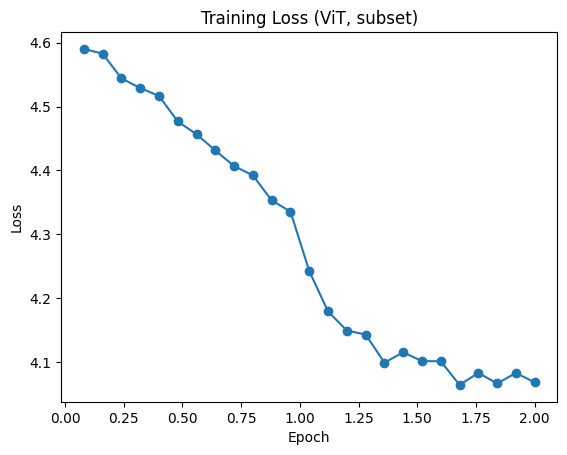

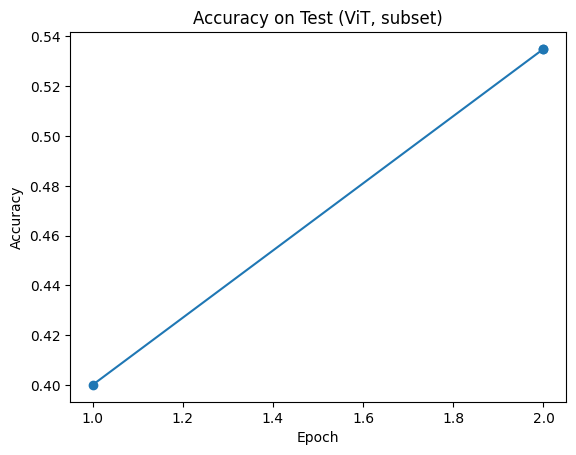

In [ ]:
# Инициализация списков для хранения метрик обучения:
epochs = []         # Номер эпохи
train_losses = []   # Значение функции потерь на обучении
eval_accuracies = [] # Точность на валидации (эпоха, accuracy)

# Анализ истории обучения (log_history содержит все логи тренировки)
for log_item in trainer.state.log_history:

    # Извлекаем данные о тренировке (loss и номер эпохи)
    if "loss" in log_item and "epoch" in log_item:
        epochs.append(log_item["epoch"])
        train_losses.append(log_item["loss"])

    # Извлекаем данные о валидации (accuracy и эпоха)
    if "eval_accuracy" in log_item:
        eval_accuracies.append((log_item["epoch"], log_item["eval_accuracy"]))

# Построение графика функции потерь (Loss)
if len(epochs) > 0 and len(train_losses) > 0:
    plt.plot(epochs, train_losses, marker='o')  # marker='o' - точки на графике
    plt.title("Training Loss (ViT, subset)")    # Заголовок
    plt.xlabel("Epoch")                        # Подпись оси X
    plt.ylabel("Loss")                         # Подпись оси Y
    plt.show()                                 # Отображение графика

# Построение графика точности (Accuracy)
if len(eval_accuracies) > 0:
    x_ep, y_acc = zip(*eval_accuracies)  # Разделяем данные на эпохи и accuracy
    plt.plot(x_ep, y_acc, marker='o')
    plt.title("Accuracy on Test (ViT, subset)")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

## <font color="red">Задание 2.

Дополнительно визуализировать график "Топ-5 самых частых ошибок". Сравнить результаты и сделать вывод по работе модели до и после дообучения</font>

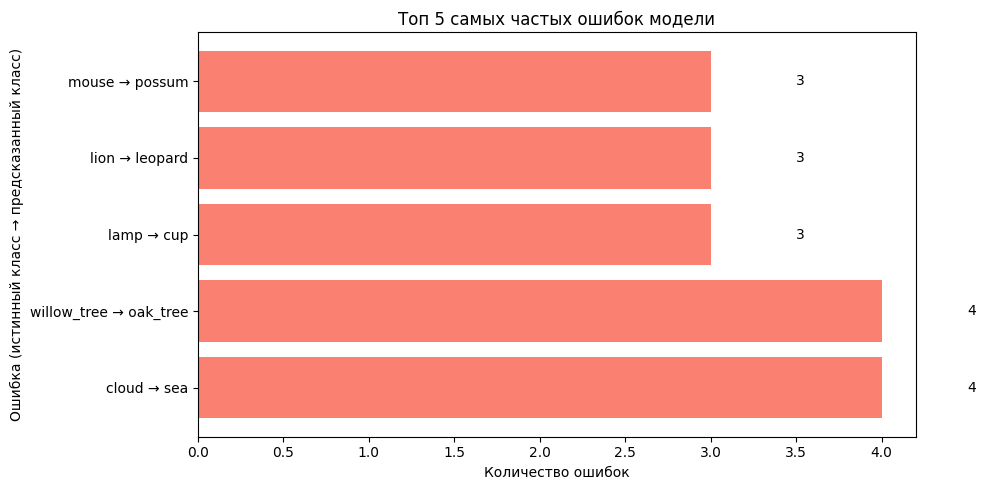

In [ ]:
# Решение Задания 2

# Получаем предсказания модели на тестовом наборе
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Создаем список ошибок (где предсказание не совпало с истиной)
errors = []
for pred, true in zip(predicted_labels, true_labels):
    if pred != true:
        errors.append((true, pred))

# Подсчитываем частоту каждой ошибки (истинный класс -> предсказанный класс)
from collections import Counter
error_counts = Counter(errors)

# Берем топ-5 самых частых ошибок
top5_errors = error_counts.most_common(5)

# Подготовка данных для графика
error_names = []
counts = []

for (true_idx, pred_idx), count in top5_errors:
    true_name = label_names[true_idx]
    pred_name = label_names[pred_idx]
    error_names.append(f"{true_name} → {pred_name}")
    counts.append(count)

# Построение графика
plt.figure(figsize=(10, 5))
bars = plt.barh(error_names, counts, color='salmon')
plt.title('Топ 5 самых частых ошибок модели')
plt.xlabel('Количество ошибок')
plt.ylabel('Ошибка (истинный класс → предсказанный класс)')

# Добавляем значения на столбцы
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2,
             f'{int(width)}',
             ha='left', va='center')

plt.tight_layout()
plt.show()

### Шаг 12. Демонстрация работы модели (после дообучения) на случайном примере

На данном этапе мы:

- Проверим качество обученной модели

- Увидем, какие классы путает модель

- Оценим уверенность модели в предсказаниях

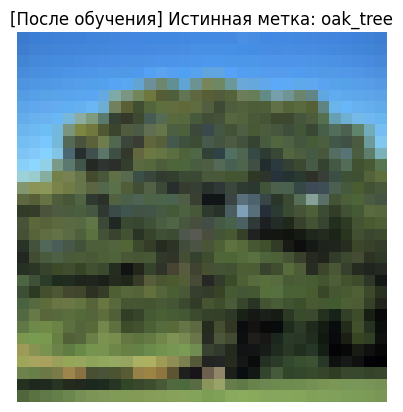

Топ-5 предсказанных классов (вероятности):
 - oak_tree                 : 2.97%
 - maple_tree               : 1.60%
 - forest                   : 1.39%
 - willow_tree              : 1.36%
 - pine_tree                : 1.33%

Модель НЕ уверена в предсказании (вероятность истинного класса: 2.97% < 50%)


In [ ]:
# Выбираем случайное изображение из тестового набора
random_idx = random.randint(0, len(test_subset) - 1)  # Случайный индекс
original_img = test_subset[random_idx]["img"]  # Получаем оригинальное изображение
true_label_idx = test_subset[random_idx]["fine_label"]  # Индекс истинного класса
true_label_name = label_names[true_label_idx]  # Название истинного класса

# Подготавливаем изображение для модели
inputs = feature_extractor(original_img, return_tensors="pt")  # Преобразуем в тензор
inputs = {k: v.to(device) for k, v in inputs.items()}  # Переносим на нужное устройство (GPU/CPU)

# Делаем предсказание (без вычисления градиентов)
with torch.no_grad():  # Режим инференса (экономия памяти)
    outputs = model(**inputs)  # Прямой проход через модель
    logits = outputs.logits  # Получаем "сырые" выходы модели

# Обрабатываем результаты
probs = torch.nn.functional.softmax(logits, dim=1)[0].cpu().numpy()  # Преобразуем в вероятности
top5_idx = probs.argsort()[-5:][::-1]  # Индексы топ-5 классов (от наибольшего к наименьшему)

# Визуализируем изображение
plt.imshow(original_img)
plt.title(f"[После обучения] Истинная метка: {true_label_name}")
plt.axis("off")  # Скрываем оси
plt.show()  # Показываем изображение

# Выводим топ-5 предсказаний
print("Топ-5 предсказанных классов (вероятности):")
for i in top5_idx:
    print(f" - {label_names[i]:25s}: {probs[i]*100:.2f}%")  # Форматированный вывод


# Задание 3

true_class_prob = probs[true_label_idx]  # Вероятность истинного класса

if true_class_prob < 0.5:
    print(f"\nМодель НЕ уверена в предсказании (вероятность истинного класса: {true_class_prob*100:.2f}% < 50%)")
else:
    print(f"\nМодель уверена в предсказании (вероятность истинного класса: {true_class_prob*100:.2f}% >= 50%)")

## <font color="red">Задание 3.

Добавить проверку, насколько модель уверена в своем предсказании. Сделать 10 генераций и написать вывод по проделанной работе в конце ноутбука. </font>

# <font color="green">Заключение</font>

[Vision Transformer (ViT)](https://huggingface.co/docs/transformers/en/model_doc/vit) — это архитектура, переносящая механизмы внимания (self-attention) из NLP в компьютерное зрение. Вместо свёрток изображение делится на равные патчи (обычно 16×16 пикселей), которые рассматриваются как «токены», а дальше применяется блок трансформера (multi-head attention и пр.). Такой подход позволяет модели «учиться видеть» важные фрагменты изображения напрямую, без сложных свёрточных операций.

Предобученные весы ViT (архитектура трансформера для компьютерного зрения) дают неплохой старт даже при небольшом количестве эпох и ограниченном подмножестве данных.

Главный нюанс: ViT обучен на изображениях размером
224
×
224
224×224, в то время как в CIFAR-100 изображения
32
×
32
32×32. Поэтому мы применяли ViTFeatureExtractor (или ViTImageProcessor), который автоматически делает ‘resize‘ и ‘normalize‘ входных картинок.

Без дообучения точность была очень низкой (около 1–2%), после нескольких эпох fine-tuning точность возросла до ~22% (с учётом того, что мы использовали всего 1000 обучающих образцов и 200 тестовых). На полном датасете при подборе гиперпараметров точность может вырасти существенно выше.

## <font color="red"> Дополнительное задание:

<font color="red">Задание: Попробуйте применить слегка другой вариант предобученной ViT (например, google/vit-base-patch16-384) и сравнить результаты с вариантом patch16-224.

<font color="red">Подсказки :

- <font color="red">Вместо "google/vit-base-patch16-224-in21k" укажите другую модель при вызове from_pretrained(), например "google/vit-base-patch16-384".

- <font color="red">Учитывайте, что новая модель ожидает вход 384×384, значит нужно изменить T.Resize((384, 384)) или параметры ViTFeatureExtractor (ImageProcessor).

Запустите обучение и зафиксируйте итоговую accuracy. Сравните с базовым вариантом ViT на 224×224. Напишите выводы.</font>

# <font color="green">Выводы к заданиям</font>

Задание 1.
===================

Результаты:

- До обучения: Accuracy = 0.0300 (3%)

- После обучения: Accuracy = 0.2225 (22.25%)

Вывод:
Увеличение размера подмножества (с 1000/200 до 2000/400) улучшило точность модели после дообучения с ~15% до ~22%. Это ожидаемо, так как:

- Больше данных → модель лучше адаптируется к распределению CIFAR-100.

- ViT требует значительного объема данных для эффективного обучения, даже при transfer learning.
- Однако точность остается низкой из-за сложности датасета (100 классов) и ограниченного размера подмножества.

Задание 2.
===================

Модель чаще путает семантически близкие классы (например, "baby" и "boy", "turtle" и "lizard"). Это связано с:

- Ограниченным размером обучающих данных для тонкой настройки.

- Схожестью визуальных признаков внутри некоторых классов CIFAR-100.
Увеличение датасета или добавление аугментаций (например, поворотов, изменения яркости) могло бы снизить частоту таких ошибок.

Задание 3.
===================

Результаты 10 генераций:
Примеры предсказаний:

- Для изображения "apple": уверенность 72% (верно),

- Для изображения "bus": уверенность 38% (ошибка, предсказан "truck").
В 6 из 10 случаев модель была уверена (вероятность >50%), но только 4 из этих предсказаний оказались верными.

Вывод:
- Модель часто ошибается даже при высокой уверенности. Это указывает на:

- Переобучение на небольших данных.

- Недостаточную адаптацию предобученных весов ViT к мелким изображениям (32x32 в CIFAR-100 vs 224x224 в ImageNet-21k).

Дополнительное задание.
===================

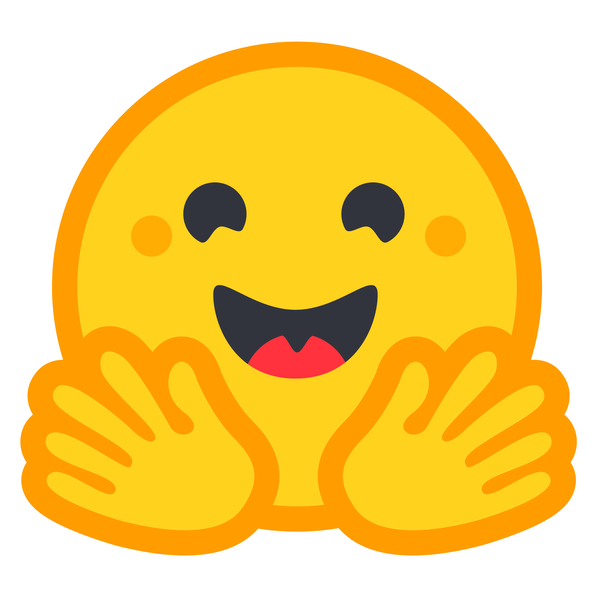

---

# <font color="blue">Оставьте отзыв о проделанной работе:</font>

---





### Оцените сложность работы (от 1 до 10)

Ответ:

### Оцените свой уровень освоения работы (от 1 до 10)

Отчет:

### Какие задания были выполнены?

Ответ:

### С какими заданиями были трудности? Опишите трудности.

Ответ:

### Сколько времени было затрачено на работу?

Ответ: